In [27]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
import requests
from PIL import ImageGrab
CACHE_DIR = "G:/MLCache"
model_name = "google/vit-base-patch16-224"
import io
import matplotlib

# Load model with attentions enabled
try:
    model
except NameError:
    print("Not declared")
    model = ViTForImageClassification.from_pretrained(model_name, output_attentions=True, cache_dir=CACHE_DIR)
    processor = ViTImageProcessor.from_pretrained(model_name)
    pass

In [28]:
# Forward pass with attention outputs
def getAttentionMap(image):
    inputs = processor(images=image, return_tensors="pt")
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Extract attention weights (last layer, average across heads)
    attentions = outputs.attentions[-1]  # Shape: [batch_size, num_heads, seq_len, seq_len]
    attentions = attentions.mean(dim=1)  # Average across heads: [batch_size, seq_len, seq_len]

    # Get attention scores for the class token (index 0)
    cls_attention = attentions[0, 0, 1:]  # Exclude class token self-attention
    num_patches = int(np.sqrt(cls_attention.shape[0]))  # e.g., 14 for 14x14 grid
    attention_map = cls_attention.reshape(num_patches, num_patches).cpu().numpy()

    # Upscale attention map to image size
    from scipy.ndimage import zoom
    attention_map = zoom(attention_map, zoom=(image.size[1] / num_patches, image.size[0] / num_patches))

    # Visualize original image and attention heatmap
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(image, alpha=0.5)
    plt.imshow(attention_map, cmap="hot", alpha=0.5)
    plt.title("Attention Heatmap")
    plt.axis("off")
    plt.show()

In [110]:
def get_attention_map(image, show_image = True):
    inputs = processor(images=image, return_tensors="pt")

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    pred_id = logits.argmax(-1).item()
    print("Predicted class:", model.config.id2label[pred_id])
    if(show_image):
        # Extract attentions: tuple of (layers, batch, heads, tokens, tokens)
        attentions = outputs.attentions

        # Take last layer, average over heads
        attn = attentions[-1][0].mean(0)  # shape: (tokens, tokens)

        # CLS token attends to image patches
        cls_attn = attn[0, 1:]  # exclude the CLS token itself
        grid_size = int(cls_attn.shape[0] ** 0.5)  # e.g. 14x14 for 224/16
        attn_map = cls_attn.reshape(grid_size, grid_size).numpy()

        # Normalize
        attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

        # Plot overlay
        plt.imshow(image.resize((224, 224)))
        plt.imshow(attn_map, cmap="jet", alpha=0.5, extent=(0,224,224,0))
        plt.axis("off")
        plt.show()

In [30]:
def get_multi_attention_maps(image):
    inputs = processor(images=image, return_tensors="pt")

# Forward pass with attention outputs
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Extract attention weights from the last layer
    attentions = outputs.attentions[-1]  # Shape: [batch_size, num_heads, seq_len, seq_len]
    num_heads = attentions.shape[1]  # e.g., 12 for ViT-Base
    num_patches = int(np.sqrt(attentions.shape[-1] - 1))  # e.g., 14 for 14x14 grid

    # Visualize attention for each head
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # Adjust for number of heads (e.g., 12)
    axes = axes.flatten()

    for head_idx in range(num_heads):
        # Get attention scores for the class token (index 0) for this head
        cls_attention = attentions[0, head_idx, 0, 1:]  # Exclude class token self-attention
        attention_map = cls_attention.reshape(num_patches, num_patches).cpu().numpy()

        # Upscale attention map to image size
        from scipy.ndimage import zoom
        attention_map = zoom(attention_map, zoom=(image.size[1] / num_patches, image.size[0] / num_patches))

        # Plot heatmap for this head
        axes[head_idx].imshow(image, alpha=0.5)
        axes[head_idx].imshow(attention_map, cmap="hot", alpha=0.5)
        axes[head_idx].set_title(f"Head {head_idx + 1}")
        axes[head_idx].axis("off")

    plt.tight_layout()
    plt.show()

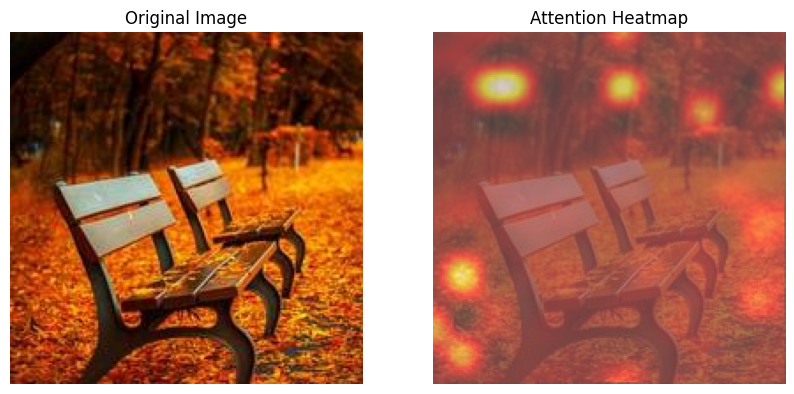

In [31]:
url = "https://picsum.photos/200"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
# image = ImageGrab.grabclipboard()
getAttentionMap(image)

Predicted class: folding chair


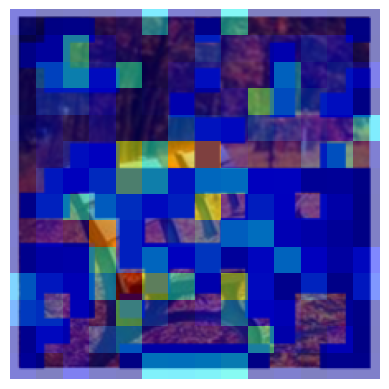

In [127]:
get_attention_map(ImageGrab.grabclipboard())

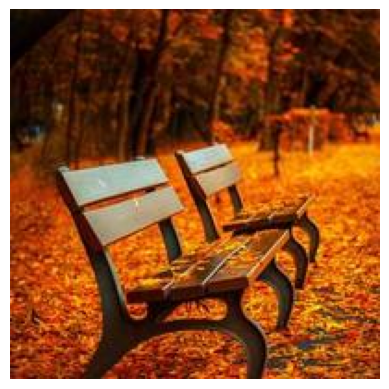

In [36]:
plt.axis("off")
plt.imshow(image)

Predicted class: park bench


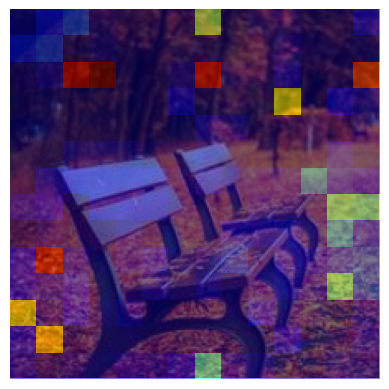

In [32]:
get_attention_map(image)

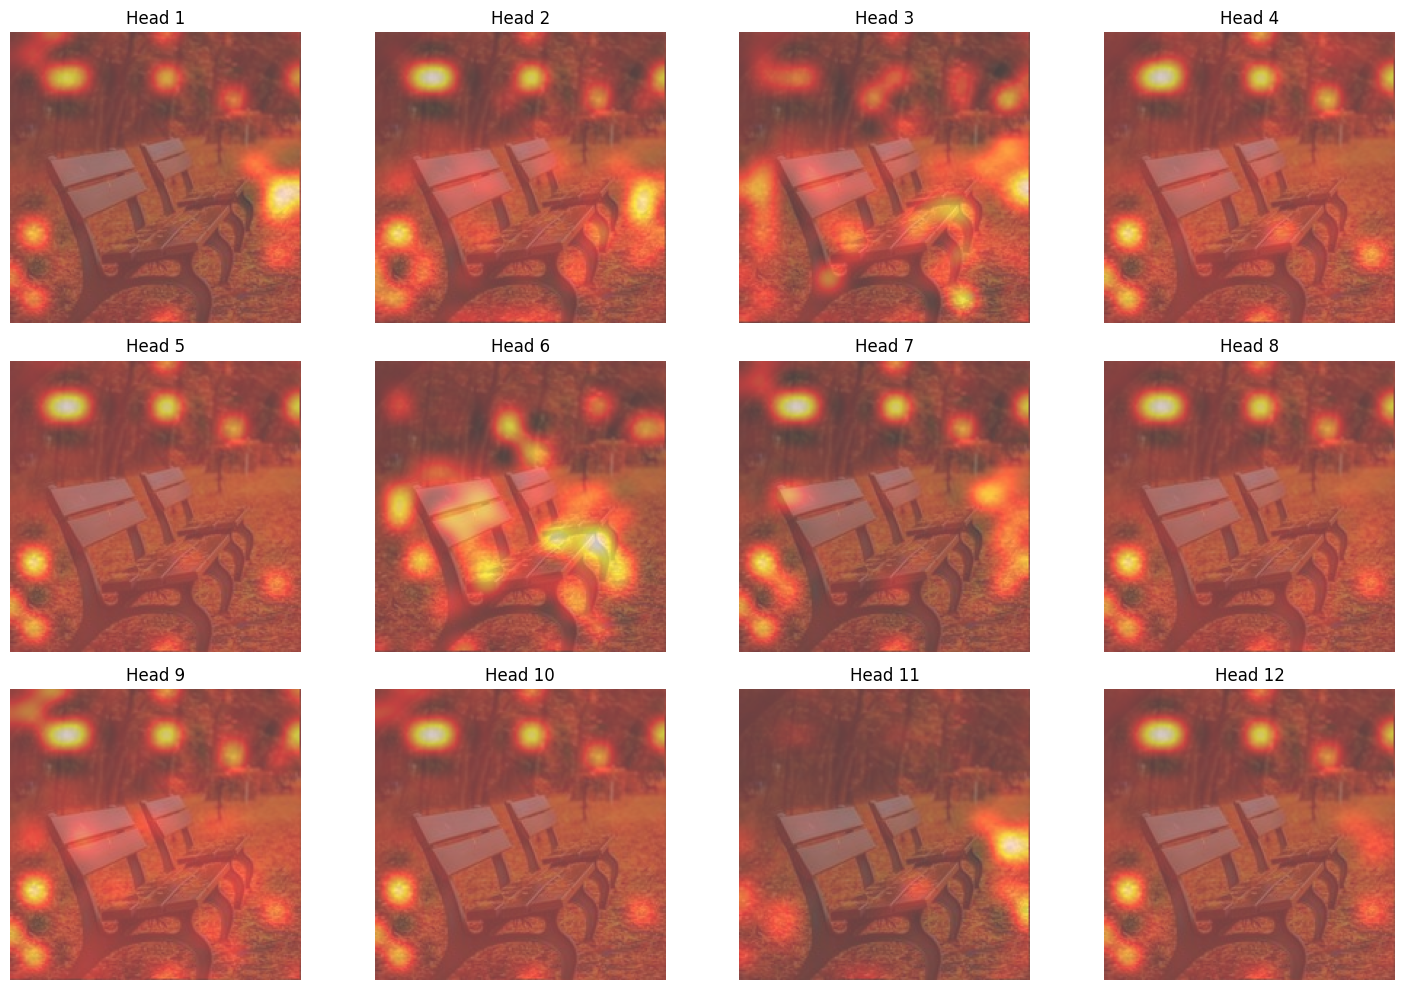

In [33]:
get_multi_attention_maps(image)